<h1> Classification Algorithms </h1>

In this notebook we apply several machine learning classification models to USD-UER exchange rate data.

In [1]:
import datetime as dt

import numpy as np
import pandas as pd
from pylab import mpl, plt
import pandas_datareader as pdr
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
%matplotlib notebook

<h2> Data Preperation </h2>

These are the parameters for our analysis. We define the start and end time of the data we want to download, and the variable train_test_divide is the datetime that seperates out training data (before this date) and testing data (after this date). The parameters for our OLS model will be the data from the two pervious days, indicated by setting lags to 2.

In [3]:
start = dt.datetime(2010, 1, 4)
train_test_divide = dt.datetime(2014, 6, 29)
end = dt.datetime(2018, 6, 29)
lags = 2

Here we load the data, calculate the returns, and also the direction (whether the returns are positive or negative on a given day).

In [4]:
data = pdr.data.DataReader('DEXUSEU', 'fred', start, end)
data.columns = ['EUR']
data['returns'] = np.log(data / data.shift(1))
data.dropna(inplace=True)
data['direction'] = np.sign(data.returns).astype(int)
print(data.head())

               EUR   returns  direction
DATE                                   
2010-01-05  1.4402 -0.001180         -1
2010-01-06  1.4404  0.000139          1
2010-01-07  1.4314 -0.006268         -1
2010-01-08  1.4357  0.003000          1
2010-01-11  1.4536  0.012391          1


Generate the lag data.

In [5]:
cols = []

for lag in range(1, lags + 1):
    col = f"lag_{lag}"
    data[col] = data["returns"].shift(lag)
    cols.append(col)

data.dropna(inplace=True)
print(data.head())

               EUR   returns  direction     lag_1     lag_2
DATE                                                       
2010-01-07  1.4314 -0.006268         -1  0.000139 -0.001180
2010-01-08  1.4357  0.003000          1 -0.006268  0.000139
2010-01-11  1.4536  0.012391          1  0.003000 -0.006268
2010-01-12  1.4523 -0.000895         -1  0.012391  0.003000
2010-01-13  1.4492 -0.002137         -1 -0.000895  0.012391


Plotting the one and two day lags against each other shows no particular pattern.

<IPython.core.display.Javascript object>


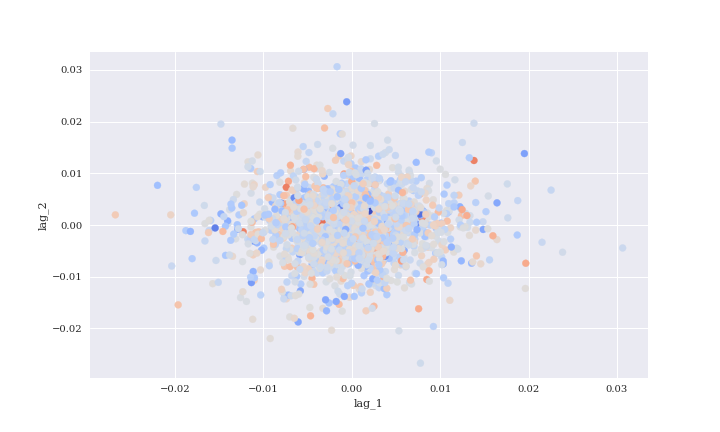

Text(0, 0.5, 'lag_2')

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(x=data[cols[0]], y=data[cols[1]], c=data['returns'], cmap="coolwarm")
plt.xlabel(cols[0])
plt.ylabel(cols[1])

<h2> Classification </h2>

Here we divide our data into training and testing samples.

In [7]:
train = data.iloc[data.index < train_test_divide].copy()
test = data.iloc[data.index >= train_test_divide].copy()

We train the models on the returns direction data.

In [8]:
C = 1

models = {
    "log_reg": linear_model.LogisticRegression(C=C),
    "gauss_nb": GaussianNB(),
    "svm": SVC(C=C)
}

In [9]:
for key, model in models.items():
    model.fit(train[cols], train['direction'])

Make prediction with each model. We make predictions on our training data as a sanity check, and on the test data to actually verify the model works.

In [10]:
for key, model in models.items():
    train[f'pos_{key}'] = model.predict(train[cols])
    test[f'pos_{key}'] = model.predict(test[cols])
test.head()

,EUR,returns,direction,lag_1,lag_2,pos_log_reg,pos_gauss_nb,pos_svm
DATE,,,,,,,,
2014-06-30,1.3690,0.004319,1,0.001542,-0.002055,1,1,1
2014-07-01,1.3681,-0.000658,-1,0.004319,0.001542,1,1,1
2014-07-02,1.3656,-0.001829,-1,-0.000658,0.004319,1,1,1
2014-07-03,1.3610,-0.003374,-1,-0.001829,-0.000658,1,1,1
2014-07-08,1.3614,0.000735,1,-0.003374,-0.001829,1,1,1


Turn the model output into direction data.

In [11]:
for key, model in models.items():
    train[f'strat_{key}'] = train[f'pos_{key}'] * train['returns']
    test[f'strat_{key}'] = test[f'pos_{key}'] * test['returns']

Sum the returns for each model. The logistic regression has ended up just sticking with the long position, but the naive Bayes and SVM models both outperform the long strategy, with SVM best overall.

In [12]:
sel = [f'strat_{key}' for key in models.keys()] + ['returns']

In [13]:
train[sel].sum().apply(np.exp)

strat_log_reg     0.980961
strat_gauss_nb    1.437016
strat_svm         1.485910
returns           0.980961
dtype: float64

In [14]:
test[sel].sum().apply(np.exp)

strat_log_reg     0.883380
strat_gauss_nb    0.928632
strat_svm         1.026065
returns           0.883380
dtype: float64

View the cumulative returns of our model on the train and test set.

<IPython.core.display.Javascript object>


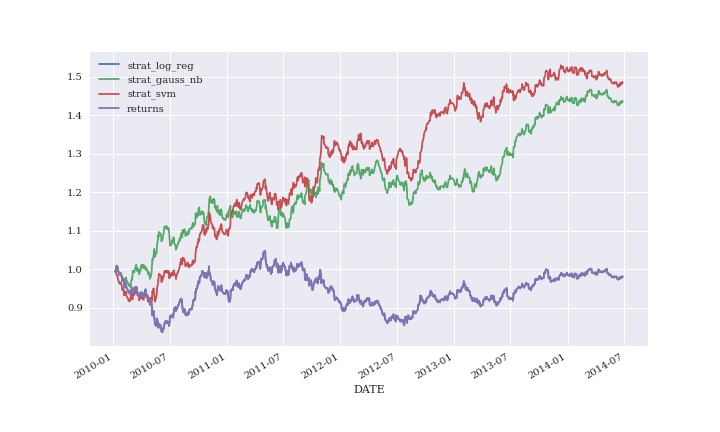

<AxesSubplot:xlabel='DATE'>

In [15]:
train[sel].cumsum().apply(np.exp).plot(figsize=(10, 6))

<IPython.core.display.Javascript object>


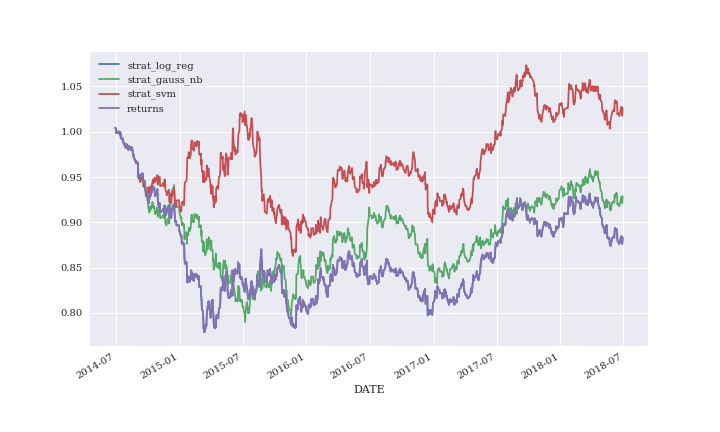

<AxesSubplot:xlabel='DATE'>

In [16]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6))